# Scattering Matrix Plugin

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FSMatrix.ipynb).

This notebook will give a demo of the tidy3d [ComponentModeler](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.ComponentModeler.html) plugin used to compute scattering matrix elements.

In [1]:
# make sure notebook plots inline
%matplotlib inline

# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import os
import gdspy

# tidy3D imports
import tidy3d as td
from tidy3d import web

# set tidy3d to only print error information to reduce verbosity
td.logging_level = 'error'

## Setup

We will simulate a directional coupler, similar to the GDS and Parameter scan tutorials.

Let's start by setting up some basic parameters.

In [2]:
# wavelength / frequency
lambda0 = 1.550                     # all length scales in microns
freq0 = td.constants.C_0 / lambda0
fwidth = freq0 / 10

# Spatial grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=14, wavelength=lambda0)

# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
mat_wg = td.Medium(permittivity=wg_n**2)
mat_sub = td.Medium(permittivity=sub_n**2)

# Waveguide dimensions

# Waveguide height
wg_height = 0.22
# Waveguide width
wg_width = 1.0
# Waveguide separation in the beginning/end
wg_spacing_in = 8
# length of coupling region (um)
coup_length = 6.0
# spacing between waveguides in coupling region (um)
wg_spacing_coup = 0.05
# Total device length along propagation direction
device_length = 100
# Length of the bend region
bend_length = 16
# Straight waveguide sections on each side
straight_wg_length = 4
# space between waveguide and PML
pml_spacing = 2

### Define waveguide bends and coupler

Here is where we define our directional coupler shape programmatically in terms of the geometric parameters

In [3]:
def bend_pts(bend_length, width, npts=10):
    """ Set of points describing a tanh bend from (0, 0) to (length, width)"""
    x = np.linspace(0, bend_length, npts)
    y = width*(1 + np.tanh(6*(x/bend_length - 0.5)))/2
    return np.stack((x, y), axis=1)

def arm_pts(length, width, coup_length, bend_length, npts_bend=30):
    """ Set of points defining one arm of an integrated coupler """
    ### Make the right half of the coupler arm first
    # Make bend and offset by coup_length/2
    bend = bend_pts(bend_length, width, npts_bend)
    bend[:, 0] += coup_length / 2
    # Add starting point as (0, 0)
    right_half = np.concatenate(([[0, 0]], bend))
    # Add an extra point to make sure waveguide is straight past the bend
    right_half = np.concatenate((right_half, [[right_half[-1, 0] + 0.1, width]]))
    # Add end point as (length/2, width)
    right_half = np.concatenate((right_half, [[length/2, width]]))

    # Make the left half by reflecting and omitting the (0, 0) point
    left_half = np.copy(right_half)[1:, :]
    left_half[:, 0] = -left_half[::-1, 0]
    left_half[:, 1] = left_half[::-1, 1]
    
    return np.concatenate((left_half, right_half), axis=0)

def make_coupler(
    length, 
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
    npts_bend=30):
    """ Make an integrated coupler using the gdspy FlexPath object. """

    # Compute one arm of the coupler
    arm_width = (wg_spacing_in - wg_width - wg_spacing_coup)/2
    arm = arm_pts(length, arm_width, coup_length, bend_length, npts_bend)
    # Reflect and offset bottom arm
    coup_bot = np.copy(arm)
    coup_bot[:, 1] = -coup_bot[::-1, 1] - wg_width/2 - wg_spacing_coup/2
    # Offset top arm
    coup_top = np.copy(arm)
    coup_top[:, 1] += wg_width/2 + wg_spacing_coup/2
    
    # Create waveguides as GDS paths
    path_bot = gdspy.FlexPath(coup_bot, wg_width, layer=1, datatype=0)
    path_top = gdspy.FlexPath(coup_top, wg_width, layer=1, datatype=1)
    
    return [path_bot, path_top]

### Create Base Simulation

The scattering matrix tool requires the "base" [Simulation](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.Simulation.html) (without the modal sources or monitors used to compute S-parameters), so we will construct that now.

We generate the structures and add a [FieldMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html?highlight=FieldMonitor) so we can inspect the field patterns.

In [4]:
gdspy.current_library = gdspy.GdsLibrary()
lib = gdspy.GdsLibrary()

# Geometry must be placed in GDS cells to import into Tidy3D
coup_cell = lib.new_cell('Coupler')

substrate = gdspy.Rectangle(
    (-device_length/2, -wg_spacing_in/2-10),
    (device_length/2, wg_spacing_in/2+10),
    layer=0)
coup_cell.add(substrate)

# Add the coupler to a gdspy cell
gds_coup = make_coupler(
    device_length,
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length)
coup_cell.add(gds_coup)

# Substrate
[oxide_geo] = td.PolySlab.from_gds(
    gds_cell=coup_cell,
    gds_layer=0,
    gds_dtype=0,
    slab_bounds=(-10, 0),
    axis=2)

oxide = td.Structure(
    geometry=oxide_geo,
    medium=mat_sub)

# Waveguides (import all datatypes if gds_dtype not specified)
coupler1_geo, coupler2_geo = td.PolySlab.from_gds(
    gds_cell=coup_cell,
    gds_layer=1,
    slab_bounds=(0, wg_height),
    axis=2)

coupler1 = td.Structure(
    geometry=coupler1_geo,
    medium=mat_wg
)

coupler2 = td.Structure(
    geometry=coupler2_geo,
    medium=mat_wg
)

# Simulation size along propagation direction
sim_length = 2*straight_wg_length + 2*bend_length + coup_length

# Spacing between waveguides and PML
sim_size = [
    sim_length,
    wg_spacing_in + wg_width + 2*pml_spacing,
    wg_height + 2*pml_spacing]

# source
src_pos = sim_length/2 - straight_wg_length/2

# in-plane field monitor (optional, increases required data storage)
domain_monitor = td.FieldMonitor(
    center = [0,0,wg_height/2],
    size = [td.inf, td.inf, 0],
    freqs = [freq0],
    name='field'
)

# initialize the simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[oxide, coupler1, coupler2],
    sources=[],
    monitors=[domain_monitor],
    run_time=50/fwidth,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())
)


[17:14:19] WARNING  No sources in simulation.                               ]8;id=588901;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=24169;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#406\406]8;;\

<Figure size 1080x720 with 2 Axes>

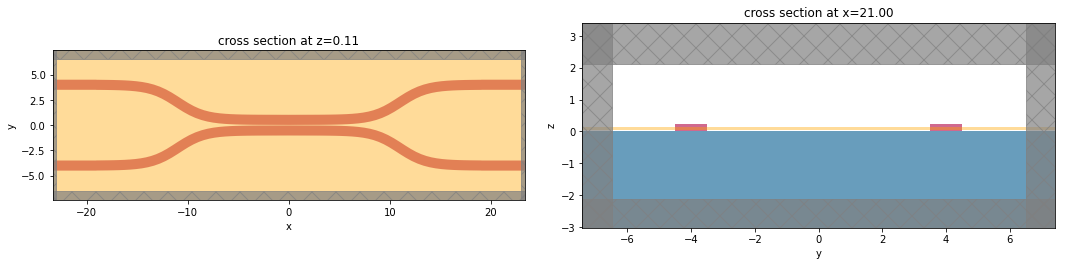

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10))
ax1 = sim.plot(z=wg_height/2, ax=ax1)
ax2 = sim.plot(x=src_pos, ax=ax2)

## Setting up Scattering Matrix Tool
Now, to use the S matrix tool, we need to defing the spatial extent of the "ports" of our system using [Port](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.Port.html) objects.

These ports will be converted into modal sources and monitors later, so they require both some mode specification and a definition of the direction that points into the system.

We'll also give them names to refer to later.

In [6]:
from tidy3d.plugins.smatrix.smatrix import Port

port_right_top = Port(
    center=[src_pos, wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=2),
    direction='-',
    name='right_top')

port_right_bot = Port(
    center=[src_pos, -wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=2),
    direction='-',
    name='right_bot')

port_left_top = Port(
    center=[-src_pos, wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=2),
    direction='+',
    name='left_top')

port_left_bot = Port(
    center=[-src_pos, -wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=2),
    direction='+',
    name='left_bot')

ports = [port_right_top, port_right_bot, port_left_top, port_left_bot]

Next, we will add the base simulation and ports to the [ComponentModeler](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.ComponentModeler.html), along with the frequency of interest and a name for saving the batch of simulations that will get created later.

In [7]:
from tidy3d.plugins.smatrix.smatrix import ComponentModeler
modeler = ComponentModeler(simulation=sim, ports=ports, freq=freq0)

[17:14:20] INFO     Using Tidy3D credentials from stored file                      ]8;id=236090;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=749588;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/auth.py#74\74]8;;\

[17:14:22] INFO     Uploaded task 'smatrix_portright_top_mode0' with task_id    ]8;id=718543;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=328601;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '3f4c9197-69ab-45fd-bdb0-f99c240b4e1e'.                                  

Output()

[17:14:24] INFO     Uploaded task 'smatrix_portright_top_mode1' with task_id    ]8;id=205474;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=978678;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    'c2d84cc1-1881-4e82-b64b-d4a25ab3629b'.                                  

Output()

[17:14:27] INFO     Uploaded task 'smatrix_portright_bot_mode0' with task_id    ]8;id=757213;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=731554;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    'd545720b-3ea4-4b6d-bab4-615d110678e5'.                                  

Output()

[17:14:29] INFO     Uploaded task 'smatrix_portright_bot_mode1' with task_id    ]8;id=645444;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=964384;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    'cd232276-724c-4031-bd1c-296999a8ef9a'.                                  

Output()

[17:14:32] INFO     Uploaded task 'smatrix_portleft_top_mode0' with task_id     ]8;id=493191;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=387659;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    'c26ab1f7-8581-4102-ab18-cb54028efaeb'.                                  

Output()

[17:14:34] INFO     Uploaded task 'smatrix_portleft_top_mode1' with task_id     ]8;id=104917;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=32999;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '790b18b5-39df-4957-816a-e57aaa394fba'.                                  

Output()

[17:14:36] INFO     Uploaded task 'smatrix_portleft_bot_mode0' with task_id     ]8;id=785340;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=708517;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '20f2d02f-8e41-4bc6-8183-e6d5b8a17f72'.                                  

Output()

[17:14:39] INFO     Uploaded task 'smatrix_portleft_bot_mode1' with task_id     ]8;id=783719;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=385671;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '65daf231-a203-4b05-aeef-f7607ff82740'.                                  

Output()

We can plot the simulation with all of the ports as sources to check things are set up correctly.

<Figure size 1080x720 with 2 Axes>

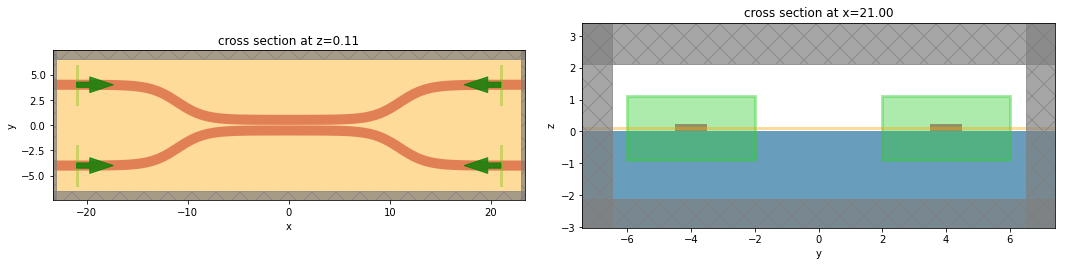

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10))
ax1 = modeler.plot_sim(z=wg_height/2, ax=ax1)
ax2 = modeler.plot_sim(x=src_pos, ax=ax2)

## Solving for the S matrix

With the component modeler defined, we may call it's `.solve()` method to run a batch of simulations to compute the S matrix.
The tool will loop through each port and create one simulation per mode index (as defined by the mode specifications) where a unique modal source is injected.
Each of the ports will also be converted to mode monitors to measure the mode amplitudes and normalization.

In [9]:
smatrix = modeler.run(path_dir='data')

[17:14:45] Started working on Batch.                                         ]8;id=161787;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=995428;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/container.py#384\384]8;;\

Output()

[17:19:51] Batch complete.                                                   ]8;id=853472;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=478;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/container.py#405\405]8;;\

[17:19:52] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=750777;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=374641;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#574\574]8;;\
                    "data/3f4c9197-69ab-45fd-bdb0-f99c240b4e1e.hdf5"                         

Output()

[17:20:14] INFO     loading SimulationData from                                 ]8;id=563822;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=895207;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#398\398]8;;\
                    data/3f4c9197-69ab-45fd-bdb0-f99c240b4e1e.hdf5                           

[17:20:15] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=263724;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=159014;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#574\574]8;;\
                    "data/c2d84cc1-1881-4e82-b64b-d4a25ab3629b.hdf5"                         

Output()

[17:20:37] INFO     loading SimulationData from                                 ]8;id=184005;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=398862;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#398\398]8;;\
                    data/c2d84cc1-1881-4e82-b64b-d4a25ab3629b.hdf5                           

[17:20:38] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=443066;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=782405;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#574\574]8;;\
                    "data/d545720b-3ea4-4b6d-bab4-615d110678e5.hdf5"                         

Output()

[17:21:00] INFO     loading SimulationData from                                 ]8;id=4910;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=741619;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#398\398]8;;\
                    data/d545720b-3ea4-4b6d-bab4-615d110678e5.hdf5                           

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=338641;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=720953;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#574\574]8;;\
                    "data/cd232276-724c-4031-bd1c-296999a8ef9a.hdf5"                         

Output()

[17:21:23] INFO     loading SimulationData from                                 ]8;id=865116;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=744778;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#398\398]8;;\
                    data/cd232276-724c-4031-bd1c-296999a8ef9a.hdf5                           

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=197341;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=874469;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#574\574]8;;\
                    "data/c26ab1f7-8581-4102-ab18-cb54028efaeb.hdf5"                         

Output()

[17:21:45] INFO     loading SimulationData from                                 ]8;id=702228;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=119215;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#398\398]8;;\
                    data/c26ab1f7-8581-4102-ab18-cb54028efaeb.hdf5                           

[17:21:46] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=411619;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=995419;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#574\574]8;;\
                    "data/790b18b5-39df-4957-816a-e57aaa394fba.hdf5"                         

Output()

[17:22:08] INFO     loading SimulationData from                                 ]8;id=193019;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=793258;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#398\398]8;;\
                    data/790b18b5-39df-4957-816a-e57aaa394fba.hdf5                           

[17:22:09] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=336138;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=874648;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#574\574]8;;\
                    "data/20f2d02f-8e41-4bc6-8183-e6d5b8a17f72.hdf5"                         

Output()

[17:22:31] INFO     loading SimulationData from                                 ]8;id=993226;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=71810;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#398\398]8;;\
                    data/20f2d02f-8e41-4bc6-8183-e6d5b8a17f72.hdf5                           

[17:22:32] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=225432;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=452977;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#574\574]8;;\
                    "data/65daf231-a203-4b05-aeef-f7607ff82740.hdf5"                         

Output()

[17:22:54] INFO     loading SimulationData from                                 ]8;id=249194;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=160362;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#398\398]8;;\
                    data/65daf231-a203-4b05-aeef-f7607ff82740.hdf5                           

## Working with Scattering Matrix

The scattering matrix returned by the solve is actually a nested dictionarty relating the port names.
For example `smatrix[name1][name2]` gives an array of shape `(m, n)` relating the coupling between the `m` modes injected into port `name1` with the `n` modes measured in port `name2`.

For example, here each waveguide has 2 modes, so we can compute the coupling between the 2 input modes in `left_top` with the 2 output modes in `right_bot` as:

In [10]:
smatrix['left_top']['right_bot']

array([[0.06405768+0.07115856j, 0.00669322-0.00306965j],
       [0.00574468-0.00463113j, 0.35245579+0.43931115j]])

Alternatively, we can convert this into a numpy array:

In [11]:
blocks_cols = []
for port_name_in, val_in in smatrix.items():
    blocks_rows = []
    for port_name_out, S_in_out in val_in.items():
        blocks_rows.append(S_in_out)
    blocks_cols.append(np.block(blocks_rows))
S = np.concatenate(blocks_cols)
print(S.shape)

(8, 8)


We can inspect `S` and note that the diagonal elements are very small indicating low backscattering.

In [12]:
print(abs(S)**2)

[[1.19474563e-04 3.84524744e-05 1.30710199e-06 1.71791191e-05
  9.88835458e-01 3.45354262e-04 9.16672365e-03 5.51433494e-05]
 [3.84105732e-05 1.81103843e-04 1.75045775e-05 1.33686022e-04
  3.46289767e-04 6.66286303e-01 5.53308841e-05 3.17179490e-01]
 [1.30942979e-06 1.74195952e-05 1.18416747e-04 3.83326123e-05
  9.16690648e-03 5.42348612e-05 9.88832771e-01 3.45066232e-04]
 [1.74761613e-05 1.33721545e-04 3.70578836e-05 1.78586736e-04
  5.44390178e-05 3.17219231e-01 3.46296752e-04 6.66280941e-01]
 [9.88824386e-01 3.47533504e-04 9.16692743e-03 5.42219524e-05
  1.19366910e-04 3.83262152e-05 1.32683404e-06 1.74373165e-05]
 [3.46757462e-04 6.66369136e-01 5.44486295e-05 3.17219373e-01
  3.70781649e-05 1.78675694e-04 1.74779135e-05 1.33136106e-04]
 [9.16639762e-03 5.51809273e-05 9.88830888e-01 3.45410542e-04
  1.32680003e-06 1.71683153e-05 1.20300400e-04 3.84957392e-05]
 [5.53905501e-05 3.17215450e-01 3.46314313e-04 6.66283607e-01
  1.75122371e-05 1.33131540e-04 3.84814298e-05 1.79949441e-04]]

Summing each rows of the matrix should give 1.0 if no power was lost.

In [13]:
np.sum(abs(S)**2, axis=0)

array([0.9985696 , 0.984358  , 0.99857286, 0.9842704 , 0.99857838,
       0.98427243, 0.99857871, 0.98422966])

Finally, we can check whether `S` is close to unitary as expected.

S times it's Hermitian conjugate should be the identy matrix.

In [14]:
mat = S @ (np.conj(S.T))

<Figure size 864x252 with 6 Axes>

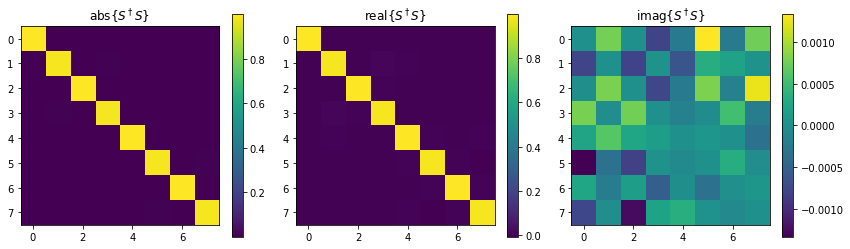

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3.5))
imabs = ax1.imshow(abs(mat))
imreal = ax2.imshow(mat.real)
imimag = ax3.imshow(mat.imag)
plt.colorbar(imabs, ax=ax1)
plt.colorbar(imreal, ax=ax2)
plt.colorbar(imimag, ax=ax3)
ax1.set_title('abs{$S^\dagger S$}')
ax2.set_title('real{$S^\dagger S$}')
ax3.set_title('imag{$S^\dagger S$}')
plt.show()

It looks pretty close, but there seems to indeed be a bit of loss (expected).

## Viewing individual Simulation Data
To verify, we may want to take a look the individual simulation data.
For that, we can load up the batch and inspect the [SimulationData](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.Simulation.html) for each task.

In [16]:
batch_data = modeler.batch.load(path_dir='data')

[17:22:58] INFO     loading SimulationData from                                 ]8;id=365804;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=796933;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#398\398]8;;\
                    data/c26ab1f7-8581-4102-ab18-cb54028efaeb.hdf5                           

[17:23:00] INFO     loading SimulationData from                                 ]8;id=521088;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=753387;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#398\398]8;;\
                    data/790b18b5-39df-4957-816a-e57aaa394fba.hdf5                           

<Figure size 1080x720 with 4 Axes>

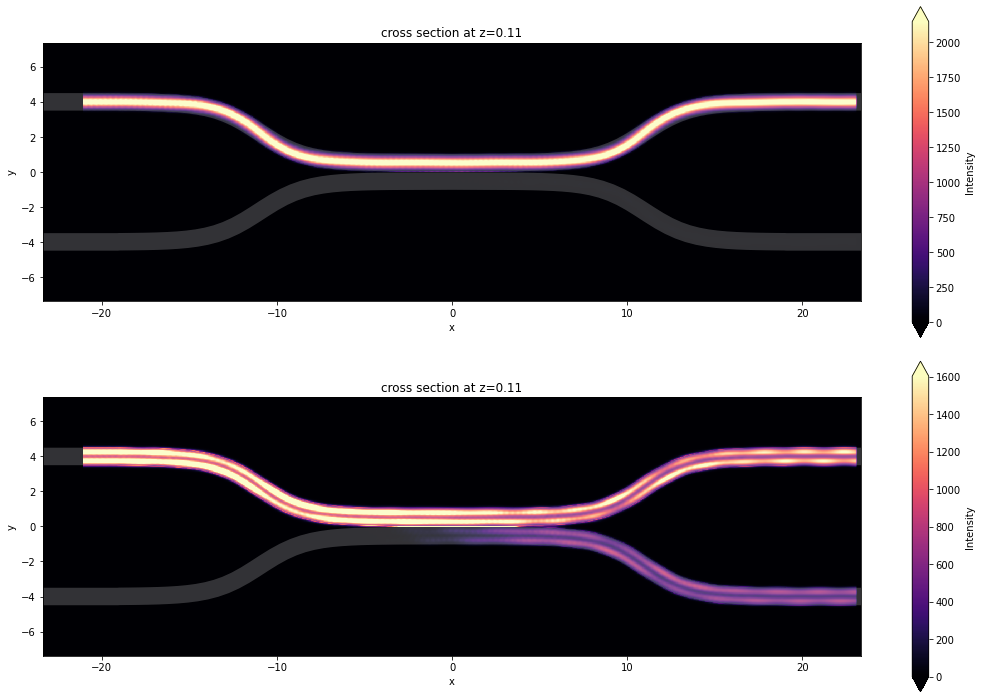

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(15, 10))
ax1 = batch_data['smatrix_portleft_top_mode0'].plot_field('field', 'int', freq=freq0, z=wg_height/2, ax=ax1)
ax2 = batch_data['smatrix_portleft_top_mode1'].plot_field('field', 'int', freq=freq0, z=wg_height/2, ax=ax2)